## Baseline - Margin

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module
Random State가  1  일 때  Basic model:  0.6634499367038532


Split_ratio:  0.2 이고 Random State가  1  일 때  Baseline model split ratio 0.2:  0.6767940501621963
Random State가  1  일 때  Advance model:  0.7380899398686606
Random State가  2  일 때  Basic model:  0.6484789144710816
Split_ratio:  0.2 이고 Random State가  2  일 때  Baseline model split ratio 0.2:  0.7420657290924915
Random State가  2  일 때  Advance model:  0.7698220784872222
Random State가  3  일 때  Basic model:  0.6999836814621411
Split_ratio:  0.2 이고 Random State가  3  일 때  Baseline model split ratio 0.2:  0.723445288393069
Random State가  3  일 때  Advance model:  0.7424415499643959
Random State가  4  일 때  Basic model:  0.5663793615001187
Split_ratio:  0.2 이고 Random State가  4  일 때  Baseline model split ratio 0.2:  0.5762075718015665
Random State가  4  일 때  Advance model:  0.7040237558351136
Random State가  5  일 때  Basic model:  0.7319877957116862
Split_ratio:  0.2 이고 Random State가  5  일 때  Baseline model split ratio 0.2:  0.7139706464118997
Random State가  5  일 때  Advance model:  0.714541795236965
Random S

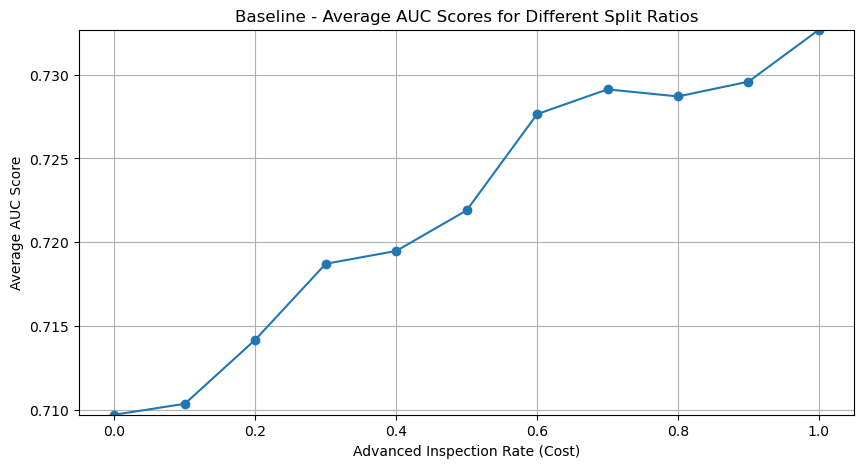

In [33]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

### 모듈 함수 불러오기

from split_and_predict_uncertainty import split_and_predict_uncertainty
from seed_everything import seed_everything
from test_predict import test_predict
#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#


# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_Baseline_margin = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

mat_file = io.loadmat('/home/iai/heo/recipe1/activeinspection_recipe1.mat')
X = mat_file['X']
X = X[:, 4:]
Y = mat_file['Y1']
Y = np.squeeze(Y)
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


### 클래스 weight 설정하기

a=87/(18384+87)
b=18384/(18384+87)
weights=[a,b]
weights=torch.FloatTensor(weights)

# loss function - crossentropy()함수

criterion = nn.CrossEntropyLoss(weights)


# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_Baseline=[]
auc_score30_split_Baseline_0_2=[]
auc_score30_split_ad_BL=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=3694
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    # optimizer 정의
    teacher_model = Teacher()
    student_model = Student()
    optimizer_advance = optim.Adam(teacher_model.parameters(), lr=learning_rate)
    optimizer_basic = optim.Adam(student_model.parameters(), lr=learning_rate)
    
    # Teacher model (advanced model 구하기)    
    
    best_teacher_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/advance_model_recipe1/advancemodel_randomstate{}'.format(i)) 

    best_student_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/basic_model_recipe1/basicmodel_randomstate{}'.format(i))
            
    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)
    

    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    test_data=pd.concat([test_X,test_y],axis=1)

    # Margin을 계산하여 uncertainty score로 사용 
    
    # Margin은 예측 확률 사이의 차이로 계산 (예: abs(probability of class 1- probability of class 0))
    
    uncertainty_scores=1/np.abs(y_predictions-0.5)
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_Baseline_margin[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_Baseline.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "Basic model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_Baseline_0_2.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "Baseline model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_BL.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_Baseline_margin = auc_scores_Baseline_margin.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_Baseline_margin, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_Baseline_margin), max(average_auc_scores_Baseline_margin))
plt.grid()
plt.show()   



In [34]:
average_auc_scores_Baseline_margin

array([0.70972012, 0.71037196, 0.7141907 , 0.71872021, 0.71948454,
       0.72190372, 0.72764439, 0.72912039, 0.72869891, 0.72957995,
       0.73267688])

In [3]:

# Baseline 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_Baseline)))

# Baseline 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_Baseline)))


0.7097201205923465
0.0574986265261416


In [4]:
# Advance 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_ad_BL)))

# Advance 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_ad_BL)))

0.7326768830603687
0.04851810465452361


## Margin - Knowledge distillation (T=1)

/home/iai/heo/recipe1_total_25_new/pytorch_module
Random State가  1  일 때  T가 1일 때 KD model:  0.7153923372102223
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7200579555344568
Random State가  1  일 때  Advance model:  0.7380899398686606
Random State가  2  일 때  T가 1일 때 KD model:  0.7310334084975078
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.7218109621014321
Random State가  2  일 때  Advance model:  0.7698220784872221
Random State가  3  일 때  T가 1일 때 KD model:  0.7334416290845794
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.7402583273993196
Random State가  3  일 때  Advance model:  0.7424415499643959
Random State가  4  일 때  T가 1일 때 KD model:  0.6243794010602104
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.6319848287048024
Random State가  4  일 때  Advance model:  0.7040237558351136
Random State가  5  일 때  T가 1일 때 KD model:  0.7404289302951181
Split_ratio:  0.2 이고 Random State가  5  일 때  model split ratio 0.2

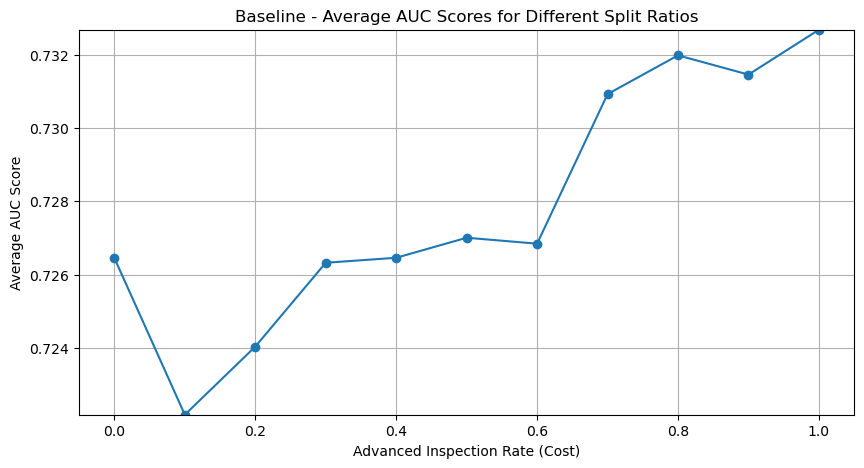

In [5]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_25_new/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_uncertainty import split_and_predict_uncertainty
from seed_everything import seed_everything
from train_teacher import train_teacher
from train_student import train_student
from test_predict import test_predict

#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#


# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_KD_margin_t1 = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

mat_file = io.loadmat('/home/iai/heo/recipe1/activeinspection_recipe1.mat')
X = mat_file['X']
X = X[:, 4:]
Y = mat_file['Y1']
Y = np.squeeze(Y)
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


### 클래스 weight 설정하기

a=87/(18384+87)
b=18384/(18384+87)
weights=[a,b]
weights=torch.FloatTensor(weights)



# loss function - crossentropy()함수

criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_KD_t1=[]
auc_score30_split_KD_0_2_t1=[]
auc_score30_split_ad_KD_t1=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=3694
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    
    # Teacher model (advanced model 구하기)    
    
    best_teacher_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/advance_model_recipe1/advancemodel_randomstate{}'.format(i))   

    best_student_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/temperature1_kd_model_recipe1/temperature1_kd_basicmodel_randomstate{}'.format(i))
            

    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # Margin을 계산하여 uncertainty score로 사용 
    
    # Margin은 예측 확률 사이의 차이로 계산 (예: abs(probability of class 1- probability of class 0))
    
    uncertainty_scores=1/np.abs(y_predictions-0.5)
    
    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    
    test_data=pd.concat([test_X,test_y],axis=1)
    
    # 예측값을 numpy 배열로 변환    
   
    
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_KD_margin_t1[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t1.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T가 1일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t1.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t1.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_KD_margin_t1 = auc_scores_KD_margin_t1.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_margin_t1, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_margin_t1), max(average_auc_scores_KD_margin_t1))
plt.grid()
plt.show()   


In [6]:
average_auc_scores_KD_margin_t1

array([0.72645548, 0.72218563, 0.72404174, 0.72632687, 0.72646249,
       0.72700866, 0.72684655, 0.73092252, 0.73197836, 0.73145431,
       0.73267692])

In [7]:
# T가 1일 때 KD 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_KD_t1)))

# KD 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_KD_t1)))

0.7264554817100509
0.05616795213680397


## Margin - Knowledge distillation (T=2)

/home/iai/heo/recipe1_total_25_new/pytorch_module
Random State가  1  일 때  T가 1일 때 KD model:  0.7704105348524409
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7761986707809162
Random State가  1  일 때  Advance model:  0.7380899398686603
Random State가  2  일 때  T가 1일 때 KD model:  0.6579881715325578
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.722540351293615
Random State가  2  일 때  Advance model:  0.7698220784872221
Random State가  3  일 때  T가 1일 때 KD model:  0.6763650704169634
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.6896498437376375
Random State가  3  일 때  Advance model:  0.7424415499643959
Random State가  4  일 때  T가 1일 때 KD model:  0.7013485046285307
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.7136813632407627
Random State가  4  일 때  Advance model:  0.7040237558351136
Random State가  5  일 때  T가 1일 때 KD model:  0.7397564087348684
Split_ratio:  0.2 이고 Random State가  5  일 때  model split ratio 0.2:

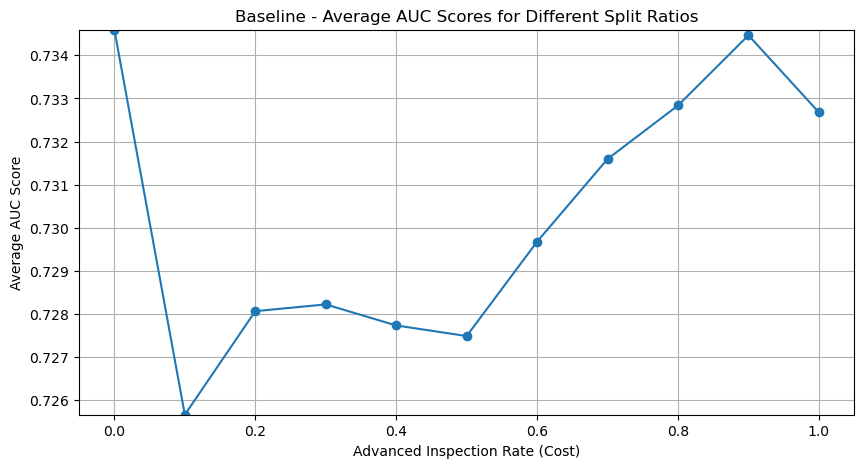

In [8]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

### 모듈 함수 불러오기

from split_and_predict_uncertainty import split_and_predict_uncertainty
from seed_everything import seed_everything
from test_predict import test_predict

#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#


# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_KD_margin_t2 = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

mat_file = io.loadmat('/home/iai/heo/recipe1/activeinspection_recipe1.mat')
X = mat_file['X']
X = X[:, 4:]
Y = mat_file['Y1']
Y = np.squeeze(Y)
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


### 클래스 weight 설정하기

a=87/(18384+87)
b=18384/(18384+87)
weights=[a,b]
weights=torch.FloatTensor(weights)



# loss function - crossentropy()함수

criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_KD_t2=[]
auc_score30_split_KD_0_2_t2=[]
auc_score30_split_ad_KD_t2=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=3694
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    
    # Teacher model (advanced model 구하기)    
    
    best_teacher_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/advance_model_recipe1/advancemodel_randomstate{}'.format(i)) 

    best_student_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/temperature2_kd_model_recipe1/temperature2_kd_basicmodel_randomstate{}'.format(i))
            

    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # Margin을 계산하여 uncertainty score로 사용 
    
    # Margin은 예측 확률 사이의 차이로 계산 (예: abs(probability of class 1- probability of class 0))
    
    uncertainty_scores=1/np.abs(y_predictions-0.5)
    
    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    
    test_data=pd.concat([test_X,test_y],axis=1)
    
    # 예측값을 numpy 배열로 변환    
   
    
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_KD_margin_t2[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t2.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T가 1일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t2.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t2.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_KD_margin_t2 = auc_scores_KD_margin_t2.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_margin_t2, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_margin_t2), max(average_auc_scores_KD_margin_t2))
plt.grid()
plt.show()   


In [11]:
average_auc_scores_KD_margin_t2

array([0.73459398, 0.72566671, 0.72806793, 0.72822439, 0.72773669,
       0.72749072, 0.72967918, 0.7315966 , 0.7328378 , 0.73446504,
       0.73267684])

In [10]:
# T가 2일 때 KD 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_KD_t2)))

# KD 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_KD_t2)))

0.7345939815913706
0.05274611139161144


## Margin - Knowledge distillation (T=5)

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module
Random State가  1  일 때  T가 1일 때 KD model:  0.7750192855447425
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7730610610016615
Random State가  1  일 때  Advance model:  0.7380899398686604
Random State가  2  일 때  T가 1일 때 KD model:  0.6580845992562703
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.701652622834085
Random State가  2  일 때  Advance model:  0.7698220784872222
Random State가  3  일 때  T가 1일 때 KD model:  0.6764478993591264
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.6905461270670148
Random State가  3  일 때  Advance model:  0.7424415499643959
Random State가  4  일 때  T가 1일 때 KD model:  0.7027553603924361
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.7080119075876257
Random State가  4  일 때  Advance model:  0.7040237558351136
Random State가  5  일 때  T가 1일 때 KD model:  0.7412374396708601
Split_ratio:  0.2 이고 Random State가  5  일 때  model split 

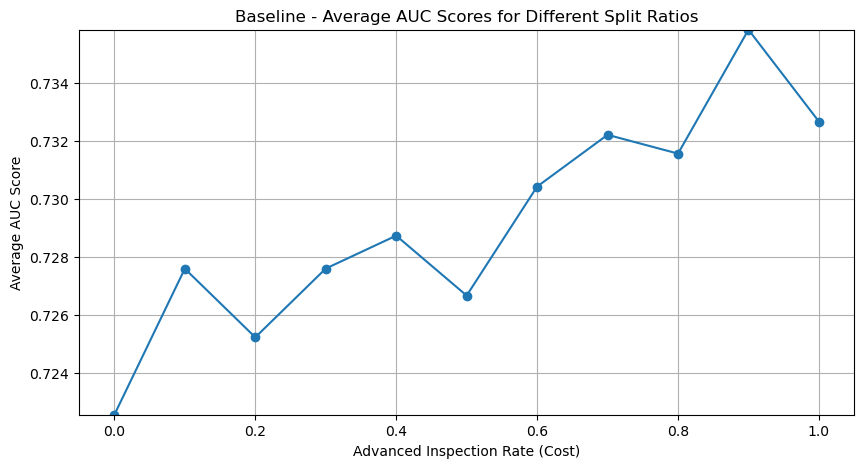

In [26]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_randomsampling import split_and_predict
from seed_everything import seed_everything
from train_teacher import train_teacher
from train_kdstudent import train_kdstudent
from train_student import train_student
from test_predict import test_predict

#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#


# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_KD_margin_t5 = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

mat_file = io.loadmat('/home/iai/heo/recipe1/activeinspection_recipe1.mat')
X = mat_file['X']
X = X[:, 4:]
Y = mat_file['Y1']
Y = np.squeeze(Y)
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


### 클래스 weight 설정하기

a=87/(18384+87)
b=18384/(18384+87)
weights=[a,b]
weights=torch.FloatTensor(weights)



# loss function - crossentropy()함수

criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_KD_t5=[]
auc_score30_split_KD_0_2_t5=[]
auc_score30_split_ad_KD_t5=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=3694
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    
    # Teacher model (advanced model 구하기)    
    
    best_teacher_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/advance_model_recipe1/advancemodel_randomstate{}'.format(i))  

    best_student_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/temperature5_kd_model_recipe1/temperature5_kd_basicmodel_randomstate{}'.format(i))
            

    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # Margin을 계산하여 uncertainty score로 사용 
    
    # Margin은 예측 확률 사이의 차이로 계산 (예: abs(probability of class 1- probability of class 0))
    
    uncertainty_scores=1/np.abs(y_predictions-0.5)
    
    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    
    test_data=pd.concat([test_X,test_y],axis=1)
    
    # 예측값을 numpy 배열로 변환    
   
    
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_KD_margin_t5[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t5.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T가 1일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t5.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t5.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_KD_margin_t5 = auc_scores_KD_margin_t5.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_margin_t5, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_margin_t5), max(average_auc_scores_KD_margin_t5))
plt.grid()
plt.show()   

In [27]:
average_auc_scores_KD_margin_t5

array([0.72254765, 0.72759283, 0.72522187, 0.72759712, 0.72873456,
       0.726664  , 0.73042958, 0.73221827, 0.73156949, 0.73584948,
       0.73267688])

In [28]:
# T가 5일 때 KD 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_KD_t5)))

# KD 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_KD_t5)))

0.7225476451855367
0.06135419722706725


## Margin - Knowledge distillation (T=10)

/home/iai/heo/recipe1_total_25_new/pytorch_module
Random State가  1  일 때  T=10일 때 KD model:  0.7731797412769997
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7704204248753856
Random State가  1  일 때  Advance model:  0.7380899398686604
Random State가  2  일 때  T=10일 때 KD model:  0.6579313039006252
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.7199405115119868
Random State가  2  일 때  Advance model:  0.7698220784872221
Random State가  3  일 때  T=10일 때 KD model:  0.6791008980140834
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.6952018553683046
Random State가  3  일 때  Advance model:  0.7424415499643959
Random State가  4  일 때  T=10일 때 KD model:  0.7047655075559776
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.7073171334757496
Random State가  4  일 때  Advance model:  0.7040237558351136
Random State가  5  일 때  T=10일 때 KD model:  0.5894700925706148
Split_ratio:  0.2 이고 Random State가  5  일 때  model split ratio 0.2

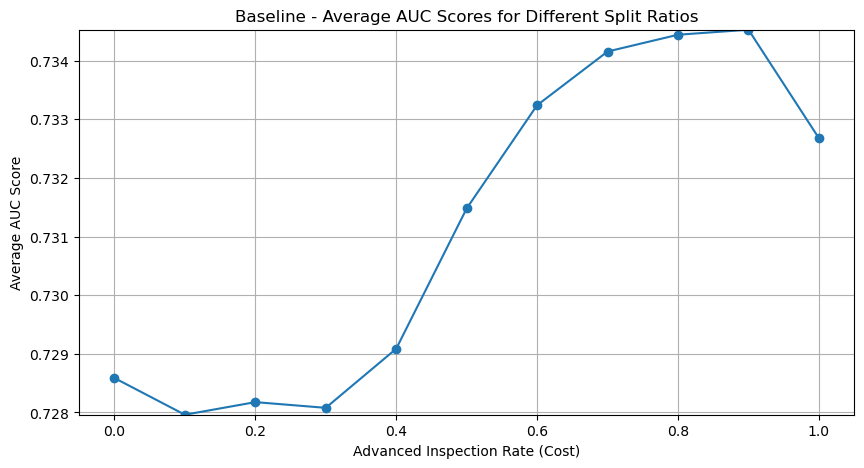

In [19]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_randomsampling import split_and_predict
from seed_everything import seed_everything
from train_teacher import train_teacher
from train_kdstudent import train_kdstudent
from train_student import train_student
from test_predict import test_predict


#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#


# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_KD_margin_t10 = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

mat_file = io.loadmat('/home/iai/heo/recipe1/activeinspection_recipe1.mat')
X = mat_file['X']
X = X[:, 4:]
Y = mat_file['Y1']
Y = np.squeeze(Y)
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


### 클래스 weight 설정하기

a=87/(18384+87)
b=18384/(18384+87)
weights=[a,b]
weights=torch.FloatTensor(weights)

# loss function - crossentropy()함수

criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_KD_t10=[]
auc_score30_split_KD_0_2_t10=[]
auc_score30_split_ad_KD_t10=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=3694
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    
    # advance model 로드하기
    
    best_teacher_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/advance_model_recipe1/advancemodel_randomstate{}'.format(i)) 

    # basic model 로드하기
    
    best_student_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/temperature10_kd_model_recipe1/temperature10_kd_basicmodel_randomstate{}'.format(i))
            
    #### Best student model로 test data 예측하기
    
    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    
    test_data=pd.concat([test_X,test_y],axis=1)
 
   

    # Margin을 계산하여 uncertainty score로 사용 
    
    # Margin은 예측 확률 사이의 차이로 계산 (예: abs(probability of class 1- probability of class 0))
    
    uncertainty_scores=1/np.abs(y_predictions-0.5)

    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_KD_margin_t10[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t10.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T=10일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t10.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t10.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_KD_margin_t10 = auc_scores_KD_margin_t10.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_margin_t10, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_margin_t10), max(average_auc_scores_KD_margin_t10))
plt.grid()
plt.show()   

In [22]:
average_auc_scores_KD_margin_t10

array([0.72858769, 0.72796111, 0.72817581, 0.72807868, 0.7290861 ,
       0.7314785 , 0.73323946, 0.73415544, 0.734442  , 0.73452735,
       0.73267684])

In [23]:
# T가 10일 때 KD 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_KD_t10)))

# KD 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_KD_t10)))

0.7285876882401034
0.06613142459493683


### Biased_Margin - VM

/home/iai/heo/recipe1_total_25_new/pytorch_module
Random state가  1 일 때 , VM model:  0.7641550953398212
Random state가  1 일 때 , Advance model:  0.7380899398686604
Random state가  2 일 때 , VM model:  0.7812302199541102
Random state가  2 일 때 , Advance model:  0.7698220784872221
Random state가  3 일 때 , VM model:  0.7625084065195031
Random state가  3 일 때 , Advance model:  0.7424415499643958
Random state가  4 일 때 , VM model:  0.6744105546324869
Random state가  4 일 때 , Advance model:  0.7040237558351136
Random state가  5 일 때 , VM model:  0.7198675725927685
Random state가  5 일 때 , Advance model:  0.7145417952369649
Random state가  6 일 때 , VM model:  0.7889122952765251
Random state가  6 일 때 , Advance model:  0.7827705910277711
Random state가  7 일 때 , VM model:  0.766204802595142
Random state가  7 일 때 , Advance model:  0.7318913679879737
Random state가  8 일 때 , VM model:  0.767177733602342
Random state가  8 일 때 , Advance model:  0.7072009257061477
Random state가  9 일 때 , VM model:  0.8153062940106021
Random stat

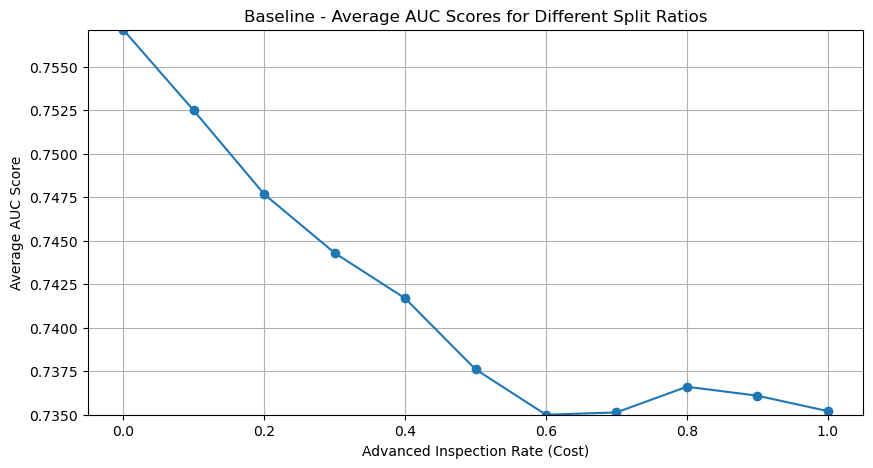

In [11]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

from split_and_predict_uncertainty import split_and_predict_uncertainty
from seed_everything import seed_everything
from virtual_features import virtual_features
from test_predict import test_predict

#---------------------------------------------------------------------------------------------------------------------------------------------------------------

# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의
split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# 데이터 업로드

mat_file = io.loadmat('/home/iai/heo/recipe1/activeinspection_recipe1.mat')
X = mat_file['X']
X = X[:, 4:]
Y = mat_file['Y1']
Y = np.squeeze(Y)
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})

# 난수 고정

seed_everything(42)

### 클래스 weight 설정하기

a=87/(18384+87)
b=18384/(18384+87)
weights=[a,b]
weights=torch.FloatTensor(weights)

# loss function - crossentropy()함수

criterion = nn.CrossEntropyLoss(weights)

# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200

auc_score30_split_VM=[]
auc_score30_split_VM_0_2=[]
auc_score30_split_ad_VM=[]

random_states=range(1, 31)
auc_scores_VM_margin = np.zeros((len(random_states), len(split_ratios)))
# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X2, val_X, train_y2, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X2)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y2),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
     
    batch_size=3694
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)

    best_teacher_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/advance_model_recipe1/advancemodel_randomstate{}'.format(i))     
    
    # 가상계측 변수 만들기

    test_X_new=pd.read_csv('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/vm_dataset/virtual_dataset_randomstate{}.csv'.format(i))

    # 가상계측 변수 Scaling해주기   

    test_X_new_scaled=scaler.transform(test_X_new)
    
 
    # 가상계측 변수가 포함된 VM model로 test data 예측하기

    test_X_new_tensor=torch.tensor(test_X_new_scaled,dtype=torch.float32)
    test_new_tensorboard=TensorDataset(test_X_new_tensor,test_y_tensor)
    test_new_loader=DataLoader(test_new_tensorboard,batch_size=batch_size,shuffle=False)  
    y_predictions=test_predict(best_teacher_model,"best_teacher_model",test_new_loader)

    # Margin을 계산하여 uncertainty score로 사용 
    
    # Margin은 예측 확률 사이의 차이로 계산 (예: abs(probability of class 1- probability of class 0))
    
    uncertainty_scores=1/np.abs(y_predictions-0.5)
    test_data=pd.concat([test_X,test_y],axis=1)

    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']     
    # Loop through the split_ratios
    for j, split_ratio in enumerate(split_ratios):
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        auc_scores_VM_margin[i, j] = auc_score
        if split_ratio==0:
            auc_score30_split_VM.append(auc_score)
            print('Random state가 ',i+1,'일 때 , VM model: ',auc_score)
        if split_ratio==1:
            auc_score30_split_ad_VM.append(auc_score)
            print('Random state가 ',i+1,'일 때 , Advance model: ',auc_score)    
    
# Calculate the average AUC scores

average_auc_scores_VM_margin = auc_scores_VM_margin.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_VM_margin, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_VM_margin), max(average_auc_scores_VM_margin))
plt.grid()
plt.show()    

In [2]:
average_auc_scores_VM_margin

array([0.75259543, 0.74206808, 0.73721768, 0.7359464 , 0.73908442,
       0.7370245 , 0.73640612, 0.73663866, 0.7368979 , 0.73550535,
       0.73612661])

In [3]:
#VM 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_VM)))

# VM 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_VM)))

0.752595430479732
0.03801917945527837


In [35]:
average_auc_scores_Baseline_margin=[0.70972012, 0.71037196, 0.7141907 , 0.71872021, 0.71948454, 0.72190372, 0.72764439, 0.72912039, 0.72869891, 0.72957995, 0.732677]
average_auc_scores_KD_margin_t1=[0.72645548, 0.72218563, 0.72404174, 0.72632687, 0.72646249, 0.72700866, 0.72684655, 0.73092252, 0.73197836, 0.73145431, 0.732677]
average_auc_scores_KD_margin_t2=[0.73459398, 0.72566671, 0.72806793, 0.72822439, 0.72773669, 0.72749072, 0.72967918, 0.7315966 , 0.7328378 , 0.73446504, 0.732677]
average_auc_scores_KD_margin_t5=[0.72254765, 0.72759283, 0.72522187, 0.72759712, 0.72873456, 0.726664  , 0.73042958, 0.73221827, 0.73156949, 0.73584948, 0.732677]
average_auc_scores_KD_margin_t10=[0.72858769, 0.72796111, 0.72817581, 0.72807868, 0.7290861 , 0.7314785 , 0.73323946, 0.73415544, 0.734442  , 0.73452735, 0.732677]

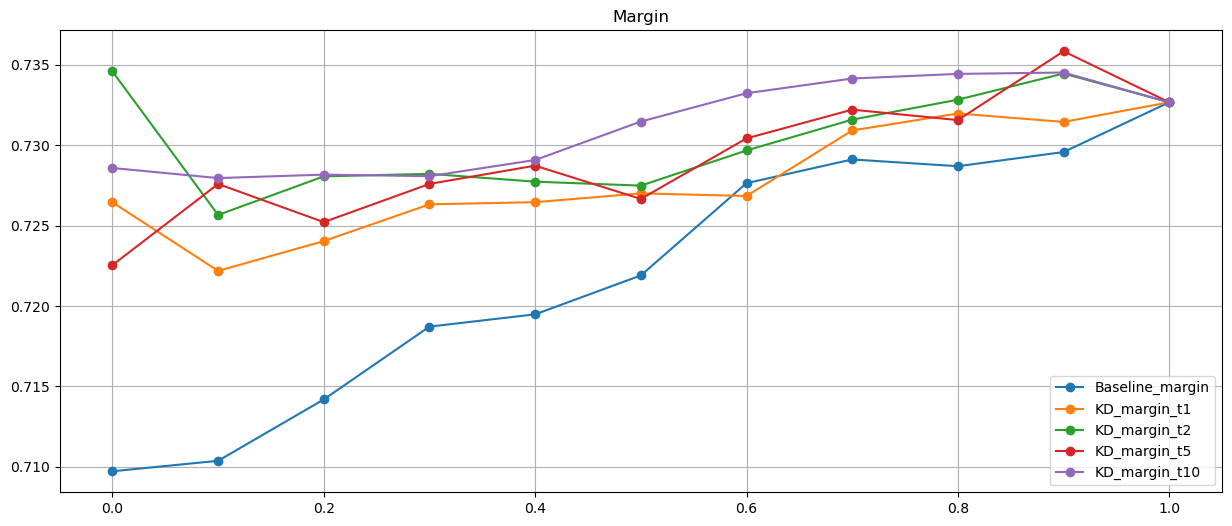

In [36]:
import matplotlib.pyplot as plt 

split_ratio=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

plt.figure(figsize=(15,6))
plt.plot(split_ratio,average_auc_scores_Baseline_margin,marker='o',label='Baseline_margin')
plt.plot(split_ratio,average_auc_scores_KD_margin_t1,marker='o',label='KD_margin_t1')
plt.plot(split_ratio,average_auc_scores_KD_margin_t2,marker='o',label='KD_margin_t2')
plt.plot(split_ratio,average_auc_scores_KD_margin_t5,marker='o',label='KD_margin_t5')
plt.plot(split_ratio,average_auc_scores_KD_margin_t10,marker='o',label='KD_margin_t10')
#plt.plot(split_ratio,average_auc_scores_VM_margin,marker='o',label='VM_margin')
plt.legend()
plt.title('Margin')
#plt.yticks([0.685,0.69,0.695,0.70,0.705,0.71,0.715,0.72,0.725,0.730,0.735,0.74,0.745,0.75,0.755])
plt.grid()
plt.show()